### Cephalo-Llama 3.2 11b Instruct inference

Reference

```bibtex
@article{Buehler_Cephalo_2024,
  title={Cephalo: Multi-Modal Vision-Language Models for Bio-Inspired Materials Analysis and Design},
  author={Markus J. Buehler},
  journal={arXiv preprint arXiv:2405.19076},
  year={2024}
}
```

In [7]:
!pip install -q -U transformers

In [ ]:
login_to_HF = False
if login_to_HF:
  token = 'hf_xxxx'
  from huggingface_hub import login
  login(token=token)

In [1]:
import requests
import torch
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor

DEVICE='cuda:0'
model_id='lamm-mit/Cephalo-Llama-3.2-11B-Vision-Instruct-128k'

model = MllamaForConditionalGeneration.from_pretrained( model_id, torch_dtype=torch.bfloat16,
                                       #_attn_implementation="flash_attention_2",
                                       trust_remote_code=True,
                                       ).to (DEVICE )

processor = AutoProcessor.from_pretrained( model_id, trust_remote_code=True, )



The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

In [44]:
import os
from tqdm.notebook import tqdm
from transformers.image_utils import load_image
from IPython.display import display, Markdown
import urllib.request
from datetime import datetime

def download_image_with_timestamp(url):
    # Define the filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    filename = f"materiomics_{timestamp}.png"
    filepath = os.path.join("./", filename)  # Save in current directory

    # Download the image
    urllib.request.urlretrieve(url, filepath)

    return filepath


def ensure_list(obj):
    if not isinstance(obj, list):
        return [obj]
    return obj

def is_url_or_filename(val) -> bool:
    # Check if it's a URL
    if isinstance(val, str) and val.startswith("http"):
        return True

    # Check if it's a filename (valid extension)
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}

    # os.path.splitext splits the file name and extension, check if the extension is in the valid set
    if isinstance(val, str) and os.path.splitext(val)[1].lower() in valid_extensions:
        return True

    return False

def ask_about_image (model, processor, question, images_input=[],  verbatim=False,temperature=0.1,show_image=False,
                     show_conversation=True,
                     max_new_tokens=256, messages=[], images=[], use_Markdown=False):

    images_input=ensure_list(images_input)
    if len (images)==0:
        if len (images_input)>0:
            for image in tqdm (images_input) :
                if is_url_or_filename(image):
                    #loads both URLs or file name per https://github.com/huggingface/transformers/blob/main/src/transformers/image_utils.py
                    image= load_image(image)
                images.append (image)

                if show_image:
                    display ( image )
    if len (messages)==0:
        messages = [
            {"role": "user", "content": [
                {"type": "image"},
                {"type": "text", "text": question}
            ]}
        ]
        input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(image, input_text, return_tensors="pt").to(model.device)

    else:
        messages.append (
                    {"role": "user", "content": [
                    {"type": "text", "text": question}
                ]}  )

    text = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=text, images=images, return_tensors="pt", ).to(DEVICE)

    generation_args = {
                "max_new_tokens": max_new_tokens,
                "temperature": temperature,
                "do_sample": True,
                }

    generate_ids = model.generate(**inputs,# eos_token_id=processor.tokenizer.eos_token_id,
                                  **generation_args)

    generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:-1]
    generated_texts = processor.decode(generate_ids[0], clean_up_tokenization_spaces=False)

    messages.append (  {"role": "assistant", "content": [  {"type": "text", "text": generated_texts}]}  )

    return generated_texts, messages, images

### Inference examples

#### Image analysis from URL

  0%|          | 0/1 [00:00<?, ?it/s]

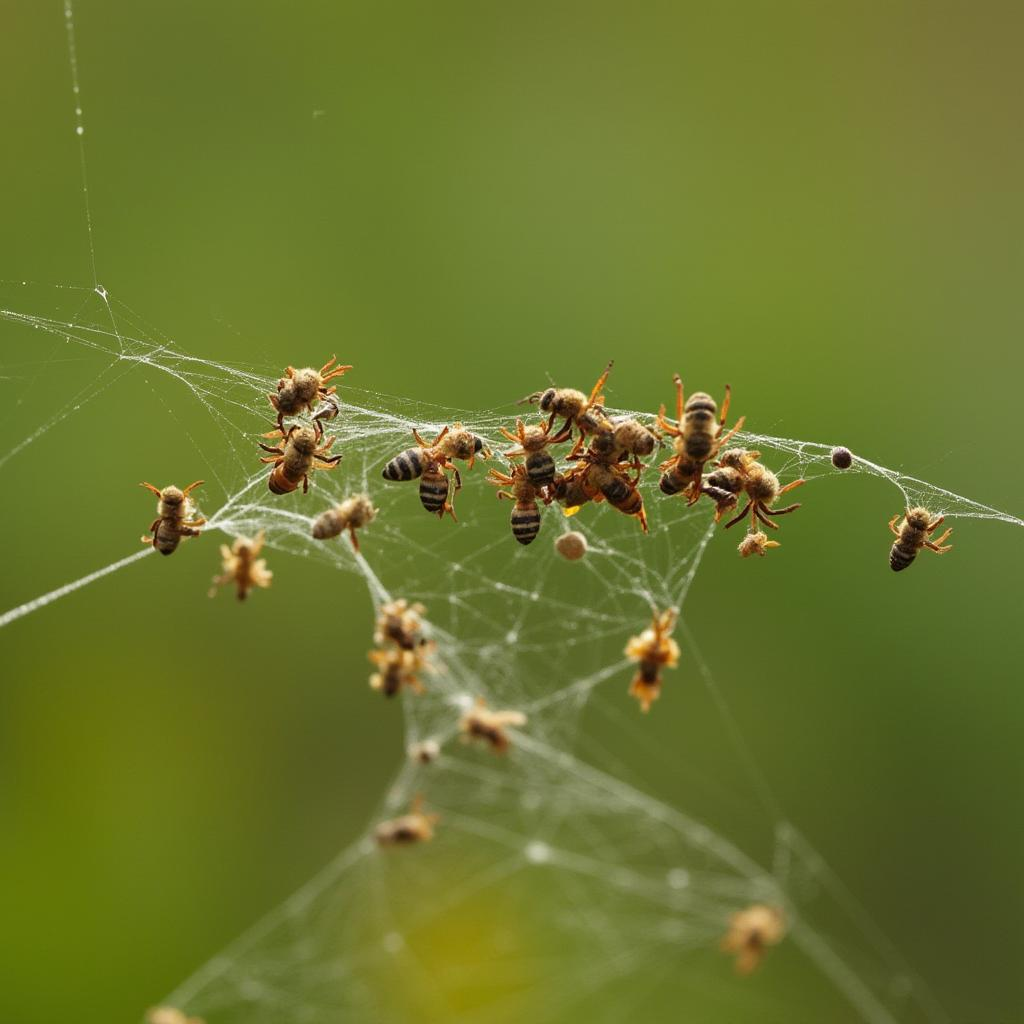

The image shows a group of bees interacting with a spider web. The bees are clustered on the web, which is composed of silk threads. The bees appear to be in close proximity to each other and the web, suggesting a potential interaction or communication between them.

**Step-by-Step Analysis:**

1. **Observation of Bees on the Web:** The image captures multiple bees on a spider web, indicating a natural interaction between the bees and the web.
2. **Behavioral Analysis:** The bees are shown in various positions on the web, some hanging from it, some standing on it, and others flying around it. This suggests that the bees are either feeding on the web or interacting with it in some way.
3. **Spider Web Structure:** The spider web is composed of silk threads, which are known for their strength and elasticity. The web's structure is complex, with multiple intersections and angles, providing a framework for the bees to interact with.

**Relevance for Materials Design for Soft Robotics:**

1. **Inspiration from Nature:** The image provides inspiration for designing soft robotic systems that mimic the natural behavior of bees interacting with spider webs. This could involve creating flexible, lightweight, and strong materials that can replicate the properties of spider silk.
2. **Multi-Agent Intelligence:** The image showcases a multi-agent system where multiple bees interact with the web, demonstrating how complex behaviors can emerge from simple interactions. This can inspire the design of soft robots that can interact with their environment in a similar manner, potentially leading to more sophisticated and adaptive robotic systems.
3. **Material Properties:** The silk threads in the web are strong and elastic, which could inspire the development of materials for soft robotics that require both strength and flexibility. This could involve the use of bio-inspired materials or advanced synthetic materials that mimic the properties of spider silk.

**Novel Design Principles:**

1. **Bio-Inspired Materials:** Design materials that mimic the strength and elasticity of spider silk for use in soft robotics.
2. **Multi-Agent Systems:** Develop soft robots that can interact with their environment in a manner similar to the bees interacting with the spider web, leading to more complex and adaptive behaviors.
3. **Flexible and Lightweight Structures:** Create robotic systems that can replicate the flexible and lightweight nature of spider webs, allowing for more natural and efficient movement and interaction with the environment.

In [49]:
question = """What is shown in this image? Use the content you see and discuss the relevance for materials design for soft robotics.

Incorporate a discussion of multi-agent intelligence.

First brainstorm step-by-step, then organize your thoughts. Then present a set of novel design principles. """

url1 = "https://huggingface.co/lamm-mit/Cephalo-Llama-3.2-11B-Vision-Instruct-128k/resolve/main/bees_on_web_multiple.jpg"

response, _, _= ask_about_image ( model, processor, question,
                                             images_input=[url1,],
                                             temperature=0.1,
                                             show_conversation=True, show_image=True,
                                             max_new_tokens=512, messages=[], images=[])

display (Markdown(response))

#### Image analysis from local file

  0%|          | 0/1 [00:00<?, ?it/s]

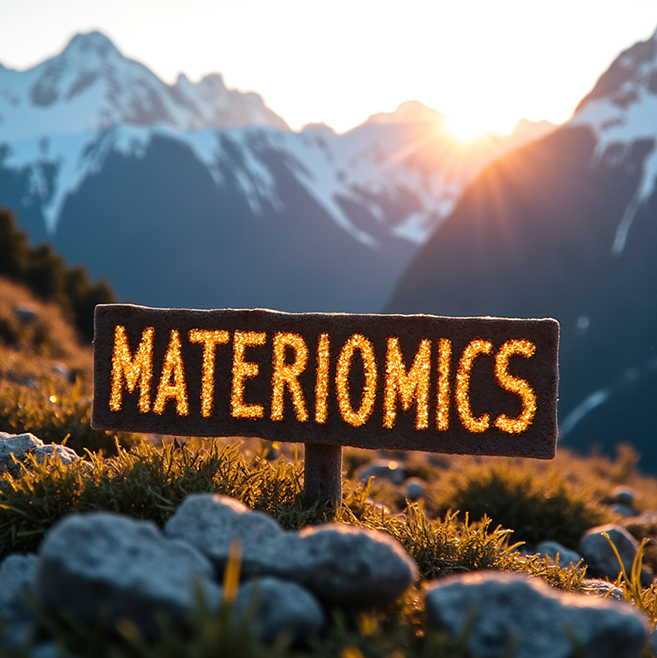

The image shows a sign in the foreground that reads "MATERIOMICS" in a stylized font, set against a backdrop of a mountainous landscape with snow-capped peaks and a bright sun shining in the distance. The sign is made of a material that appears to be a composite or hybrid material, possibly a combination of natural and synthetic elements, as indicated by the rough texture and the way it reflects the light.

Materiomics is a term that refers to the study of the structure and properties of materials at the molecular level. This field combines materials science and genomics to understand how the molecular composition of materials affects their properties and behavior. The image suggests that the sign is made from a material that has been engineered to have specific properties, possibly inspired by natural materials found in the mountains.

The relevance of this image for materials design is that it highlights the potential for creating advanced materials with unique properties by combining different materials and understanding their molecular structure. The use of natural materials as inspiration for synthetic materials is a key aspect of biomimetics, which involves mimicking the structures and functions of natural materials to create new materials with improved properties. The image implies that the material used for the sign has been designed to be durable, weather-resistant, and visually appealing, making it suitable for outdoor use in harsh environments.

In [41]:
init_instr = 'You carefully study the image and provide a detailed analysis.\n\n'

question = init_instr+"""What is shown in this image, and what is the relevance for materials design?

First brainstorm, then organize your thoughts, then respond."""

url = "https://huggingface.co/lamm-mit/Cephalo-Llama-3.2-11B-Vision-Instruct-128k/resolve/main/materiomics.png"
full_path = download_image_with_timestamp(url) #instead of downloading the file, you can point it to any local file

response, messages,images= ask_about_image ( model, processor, question,
                                             images_input=[full_path,],
                                             temperature=0.1,
                                             show_conversation=True, show_image=True,
                                             max_new_tokens=512, messages=[], images=[])


display (Markdown(response))

#### Multiple queries

  0%|          | 0/1 [00:00<?, ?it/s]

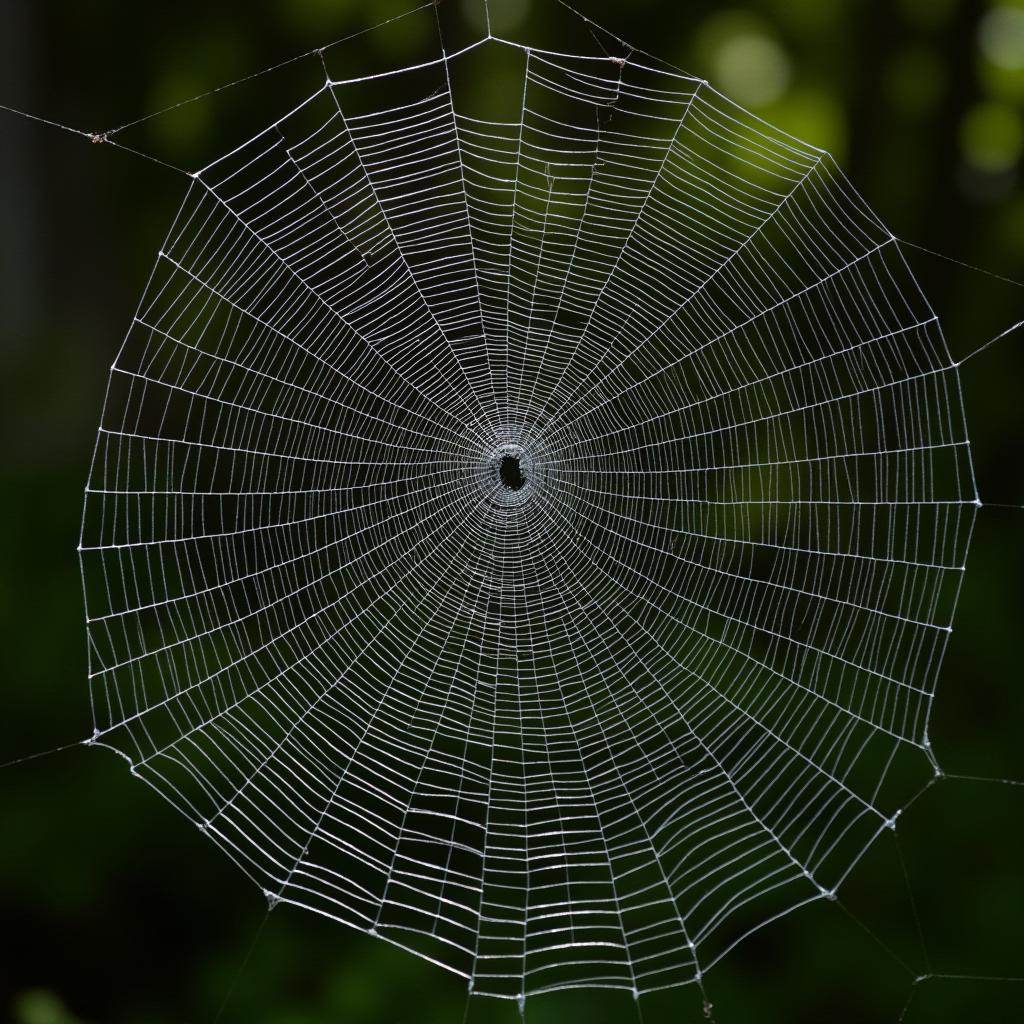

The image shows a detailed view of a spider web, specifically the orb web of a spider. The web is composed of radial threads that extend outward from the center, forming a circular pattern. The radial threads are connected by spiral threads that form a concentric pattern around the center. The web is made up of silk fibers produced by the spider, which are incredibly strong and flexible due to their unique molecular structure. The web's design allows it to capture prey effectively, with the radial threads providing structural support and the spiral threads trapping insects that fly into the web. The image highlights the intricate and complex architecture of the spider web, showcasing its efficiency and adaptability as a hunting tool.

In [38]:
init_instr = 'You are a materials scientist. You carefully study the image, and respond accurately. Think step-by-step.\n\n'

question = init_instr+"""What is shown in this image?"""

url = "https://huggingface.co/lamm-mit/Cephalo-Llama-3.2-11B-Vision-Instruct-128k/resolve/main/giant_web.jpg"
full_path = download_image_with_timestamp(url)

response, messages, images= ask_about_image (model, processor, question,
                                             images_input=[full_path,],
                                             temperature=0.1,
                                             show_conversation=True, show_image=True,
                                             max_new_tokens=512, messages=[], images=[])


display (Markdown(response))


##### Now we provide a second query. We pass the messages object from the earlier inference step into the function, along with the images list (both are returned from the earlier call)

In [39]:
question = """Develop a detailed material design for a fracture-resistant textile. Provide a clearly reasoned list of design principles."""

response, messages, images= ask_about_image ( model, processor, question,
                                             images_input=[full_path,],
                                             temperature=0.1,
                                             show_conversation=True, show_image=False,
                                             max_new_tokens=512, messages=messages, images=images)


display (Markdown(response))

To develop a fracture-resistant textile, several design principles can be applied based on the study of natural spider silk:

1. **Hierarchical Structure**: Incorporate a hierarchical structure similar to spider silk, which combines nanoscale fibers into larger fibers and then into yarns. This hierarchical structure enhances mechanical strength and toughness.

2. **Nano-Scale Fibers**: Use nanoscale fibers that mimic the diameter and properties of spider silk fibers. These fibers should be composed of materials that can withstand high stress and strain.

3. **Cross-Linked Network**: Design a cross-linked network of fibers to provide additional strength and flexibility. This network can be achieved through chemical or physical cross-linking methods.

4. **Multi-Directional Reinforcement**: Incorporate multi-directional reinforcement to enhance the material's ability to withstand various types of stress. This can be achieved through the use of different fiber orientations or the incorporation of nanoparticles.

5. **Self-Healing Properties**: Incorporate self-healing properties into the material to repair minor damages and prevent further cracking. This can be achieved through the use of shape-memory polymers or other self-healing materials.

6. **Bio-Inspired Materials**: Use bio-inspired materials that mimic the properties of spider silk, such as high strength, toughness, and flexibility. These materials can be derived from natural sources or synthesized using biomimetic techniques.

7. **Optimized Fiber Alignment**: Optimize the alignment of fibers within the material to maximize strength and toughness. This can be achieved through techniques such as drawing, stretching, or other mechanical processes.

8. **Surface Treatment**: Apply surface treatments to enhance the material's adhesion and friction properties, similar to the sticky properties of spider silk.

9. **Multi-Phase Composites**: Use multi-phase composites that combine different materials with varying properties to create a material with a unique combination of strength, toughness, and flexibility.

10. **Testing and Optimization**: Test the material under various conditions to identify areas for improvement and optimize its performance. This can involve mechanical testing, environmental testing, and durability testing.

By incorporating these design principles, a fracture-resistant textile can be developed that mimics the strength and durability of spider silk.

In [40]:
question = """Thank you. Now summarize as JSON."""

response, messages, images= ask_about_image ( model, processor, question,
                                             images_input=[full_path,],
                                             temperature=0.1,
                                             show_conversation=True, show_image=False,
                                             max_new_tokens=512, messages=messages, images=images)


display (Markdown(response))

Here is a summary of the design principles for a fracture-resistant textile in JSON format:

```
{
  "name": "Fracture-Resistant Textile",
  "description": "A textile designed to mimic the properties of spider silk for enhanced strength and durability.",
  "design_principles": [
    {
      "name": "Hierarchical Structure",
      "description": "Combines nanoscale fibers into larger fibers and then into yarns for enhanced mechanical strength and toughness."
    },
    {
      "name": "Nano-Scale Fibers",
      "description": "Uses nanoscale fibers with diameters and properties similar to spider silk fibers."
    },
    {
      "name": "Cross-Linked Network",
      "description": "Incorporates a cross-linked network of fibers for additional strength and flexibility."
    },
    {
      "name": "Multi-Directional Reinforcement",
      "description": "Incorporates multi-directional reinforcement to enhance the material's ability to withstand various types of stress."
    },
    {
      "name": "Self-Healing Properties",
      "description": "Incorporates self-healing properties to repair minor damages and prevent further cracking."
    },
    {
      "name": "Bio-Inspired Materials",
      "description": "Uses bio-inspired materials that mimic the properties of spider silk, such as high strength, toughness, and flexibility."
    },
    {
      "name": "Optimized Fiber Alignment",
      "description": "Optimizes the alignment of fibers within the material to maximize strength and toughness."
    },
    {
      "name": "Surface Treatment",
      "description": "Applies surface treatments to enhance the material's adhesion and friction properties."
    },
    {
      "name": "Multi-Phase Composites",
      "description": "Uses multi-phase composites that combine different materials with varying properties to create a material with a unique combination of strength, toughness, and flexibility."
    },
    {
      "name": "Testing and Optimization",
      "description": "Tests the material under various conditions to identify areas for improvement and optimize its performance."
    }
  ]
}
```